# Stock Index Prediction Based on Wavelet Transformation and ARMA-ML

- [Wavelet Transformation](#Wavelet-Transformation)
- [ARMA Model](#ARMA-Model)
- [ARMA_GBR/SVR](#ARMA_GBR/SVR)
  - [GBR](#GBR)
  - [SVR](#SVR)
  - [GBR+SVR](#GBR+SVR)  
- [Conclusion](#Conclusion)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
import statsmodels.api as sm
import pywt
import copy
import warnings
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor as GBR
from sklearn.metrics import explained_variance_score, mean_absolute_error, mean_squared_error, r2_score
from model import WT, AR_MA, NonlinReg, ModelEvaluation

D:\Software\Anaconda\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# import data
df_HS300 = pd.read_csv('df_000300.csv', header=0, index_col=0, encoding='utf-8')
df_HS300.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,AMT
2010-01-04,3592.468,3597.748,3535.229,3535.229,6.610108e+09,9.341984e+10
2010-01-05,3545.186,3577.526,3497.661,3564.038,8.580964e+09,1.283024e+11
2010-01-06,3558.700,3588.832,3541.173,3541.727,7.847312e+09,1.210460e+11
2010-01-07,3543.160,3558.556,3452.769,3471.456,8.035004e+09,1.204362e+11
2010-01-08,3456.908,3482.083,3426.698,3480.130,6.079025e+09,9.019096e+10


# Wavelet Transformation

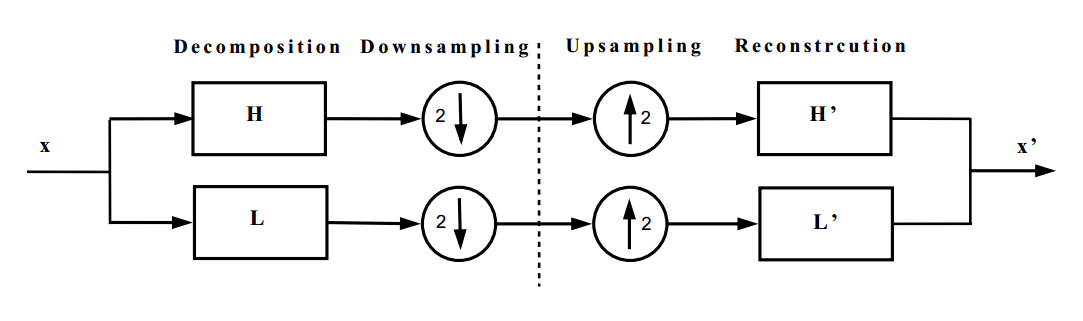

In [4]:
Image(filename='image/1.png', width=600)

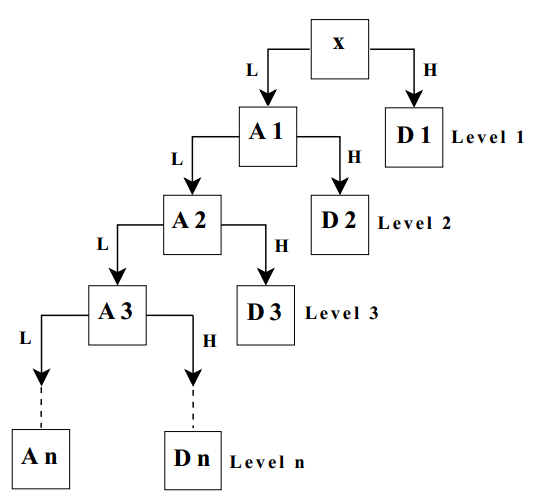

In [5]:
Image(filename='image/2.png', width=300)

\begin{aligned}
x(t) & = A_{1}(t)+D_{1}(t)\\
& = A_{2}(t)+D_{2}(t)+D_{1}(t)\\
& = A_{3}(t)+D_{3}(t)+D_{2}(t)+D_{1}(t)\\
& = A_{n}(t)+D_{n}(t)+D_{n-1}(t)+...D_{1}(t)
\end{aligned}

In [6]:
start_day = '2010-01-04'
end_day = '2012-12-27'
test = df_HS300.loc[start_day:end_day,:]
test_C = test['CLOSE']

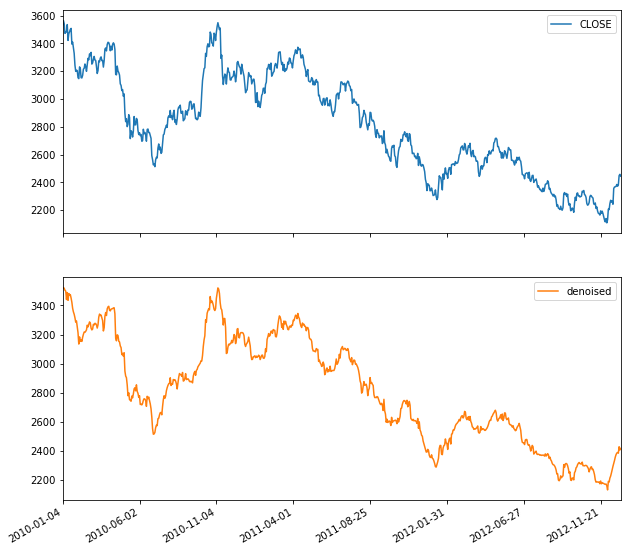

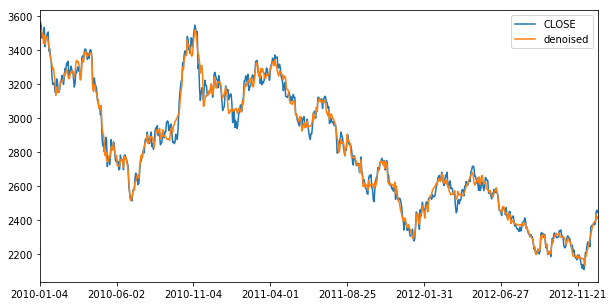

In [7]:
coeff = WT(test_C, plot=True)

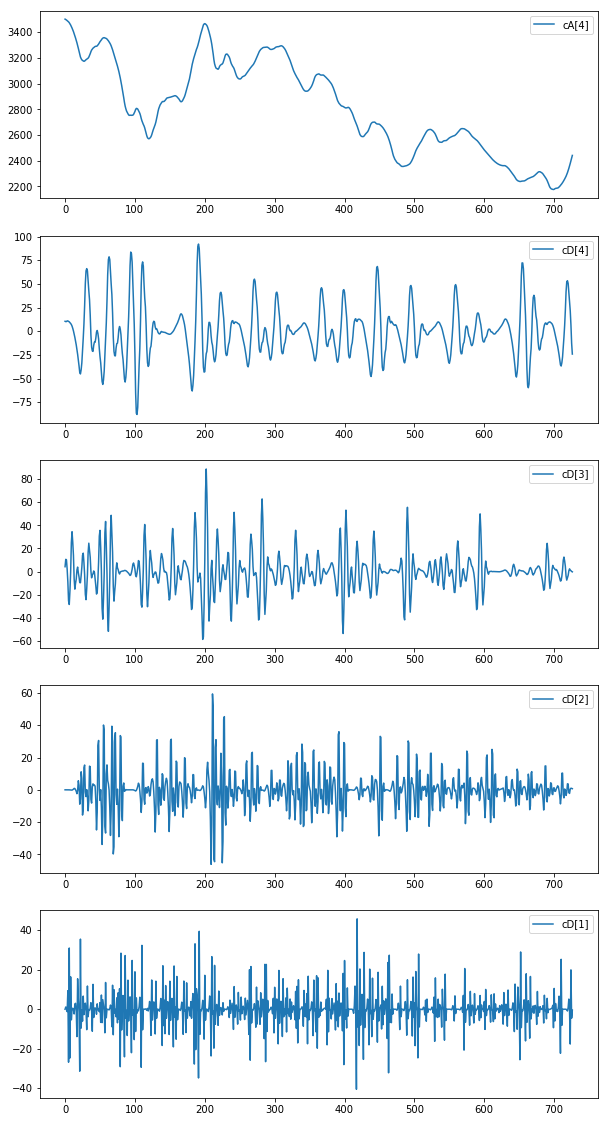

In [8]:
fig, ax =  plt.subplots(len(coeff), 1, figsize=(10, 20))
for i in range(len(coeff)):
    if i == 0:
        ax[i].plot(coeff[i], label = 'cA[%.0f]'%(len(coeff)-i-1))
        ax[i].legend(loc = 'best')
    else:
        ax[i].plot(coeff[i], label = 'cD[%.0f]'%(len(coeff)-i))
        ax[i].legend(loc = 'best')

# ARMA Model

$$Z_{t}=\varphi_{1}Z_{t-1}+\varphi_{2}Z_{t-2}+...+\varphi_{p}Z_{t-p}+a_{t}-\theta_{1}a_{t-1}-...-\theta_{q}a_{t-q}$$

$$\varphi_{p}(L)Z_{t} = \varphi_{q}(L)a_{t}$$

In [9]:
for i in range(1, len(coeff)):
    dftest = adfuller(coeff[i], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical value(%s)' % key] = value
    print((pd.DataFrame(dfoutput, columns=['cD[%.0f]'%(len(coeff)-i)])))
    print('\n')

                                    cD[4]
Test Statistic              -9.123139e+00
p-value                      3.165415e-15
#Lags Used                   2.000000e+01
Number of observations Used  7.060000e+02
Critical value(1%)          -3.439646e+00
Critical value(5%)          -2.865643e+00
Critical value(10%)         -2.568955e+00


                                    cD[3]
Test Statistic              -1.044076e+01
p-value                      1.524208e-18
#Lags Used                   2.000000e+01
Number of observations Used  7.060000e+02
Critical value(1%)          -3.439646e+00
Critical value(5%)          -2.865643e+00
Critical value(10%)         -2.568955e+00


                                    cD[2]
Test Statistic              -1.305228e+01
p-value                      2.129838e-24
#Lags Used                   2.000000e+01
Number of observations Used  7.060000e+02
Critical value(1%)          -3.439646e+00
Critical value(5%)          -2.865643e+00
Critical value(10%)         -2

Use [ADF](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) test to test the stationarity of reconstructed detail component. We can find all detail components pass the test, since the p-value is extremely small

The premise of [ARMA(p, q)](https://en.wikipedia.org/wiki/Autoregressive%E2%80%93moving-average_model) is that the time series must be stationary. And it can be proved that all the reconstructed detail component of wavelet tranformed sequence is stationary sequence

In [10]:
results = AR_MA(coeff)

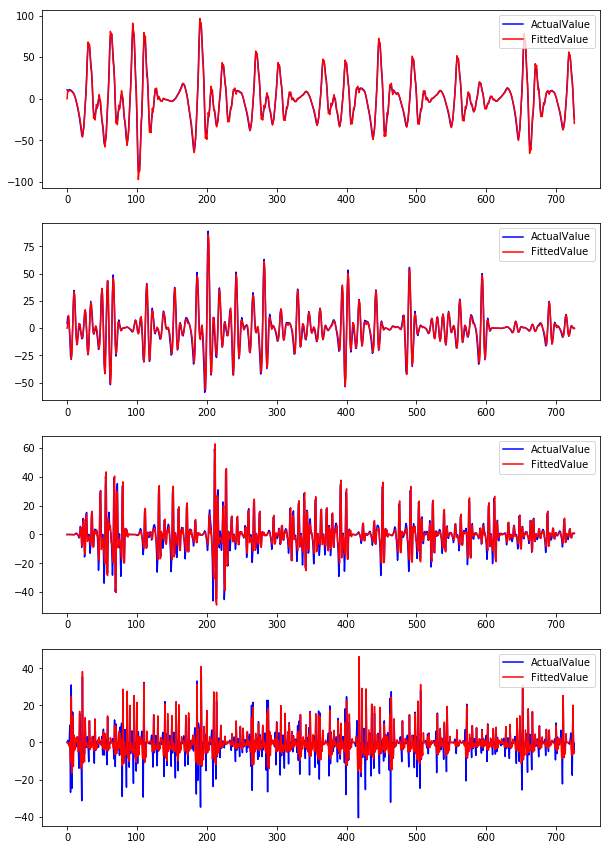

In [11]:
plt.figure(figsize=(10,15))
for i in range(len(results)):
    plt.subplot(len(results), 1, i+1)
    plt.plot(coeff[i+1], 'blue', label='ActualValue')
    plt.legend(loc='upper right')
    plt.plot(results[i].fittedvalues, 'red', label='FittedValue')
    plt.legend(loc='upper right')

# ARMA_GBR/SVR

Use the former 4 days' close price to predict the next day's close price. Using 150-day rolling windown to make prediction. Finally, try to make a prediction of 30-day close price.

## [GBR](https://en.wikipedia.org/wiki/Gradient_boosting)

In [12]:
features = 4 # this number is derived from the paper "The stock price based on the ARIMA_SVM combination model _ cheng changpin.(Chinese)". Since the prediction is the best when using 4 days close price to predict
forward =30
window = 150 # the rolling window should be as large as possible. Better larger than 100, since the time series ARMA model can't get inverted matrics if the time series is too short 
length = 1
index_predict, index_real = [], []
for i in range(forward):
    test_window = test_C[i:i+window]
    coeff = WT(test_window, lv=4, n=4)
    results = AR_MA(coeff)
    Y_ = NonlinReg(coeff, regressor='GBR', length=length, features = features)[-1:]
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(window, window+length-1, dynamic=True))
    index_predict.append(Y_)
    index_real.append(test_C[i+window:i+window+length].values)

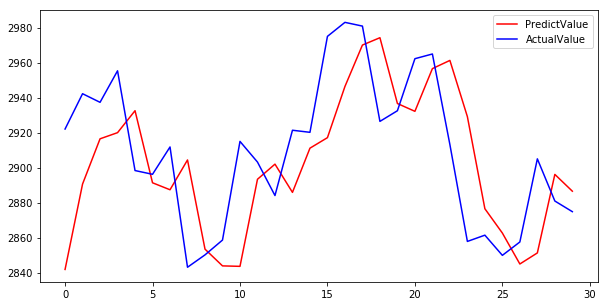

In [13]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict, 'red', label='PredictValue')
plt.legend(loc='best')
plt.plot(np.array(index_real)[:,0], 'blue', label='ActualValue') 
plt.legend(loc='best')

In [14]:
df_GBR = ModelEvaluation(index_predict, index_real, model_name = 'GBR_Model')
df_GBR

,ev,mae,mse,r2
GBR_Model,0.084507,30.393337,1426.833774,0.046767


## [SVR](https://en.wikipedia.org/wiki/Support_vector_machine#Regression)

In [15]:
features = 4
forward =30
window = 150
length = 1
index_predict1, index_real1 = [], []
for i in range(forward):
    test_window = test_C[i:i+window]
    coeff = WT(test_window, lv=4, n=4)
    results = AR_MA(coeff)
    Y_ = NonlinReg(coeff, regressor='SVR', length=length, features = features)[-1:]
    D_series = []
    for j in range(len(results)):
        D_series.append(results[j].predict(window, window+length-1, dynamic=True))
    index_predict1.append(Y_)
    index_real1.append(test_C[i+window:i+window+length].values)

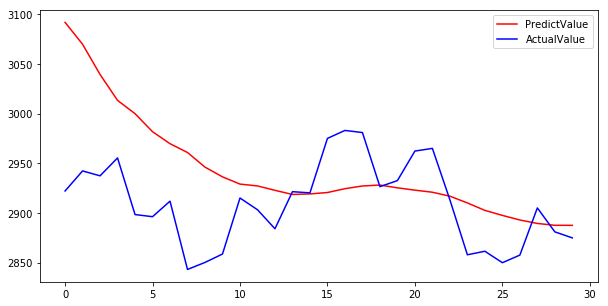

In [16]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict1, 'red', label='PredictValue')
plt.legend(loc='best')
plt.plot(np.array(index_real1)[:,0], 'blue', label='ActualValue') 
plt.legend(loc='best')

In [17]:
df_SVR = ModelEvaluation(index_predict1, index_real1, model_name = 'SVR_Model')
df_SVR

,ev,mae,mse,r2
SVR_Model,-0.246318,51.662584,4424.65077,-0.658574


## GBR+SVR

In [18]:
index_predict2 = (np.array(index_predict)+np.array(index_predict1))/2

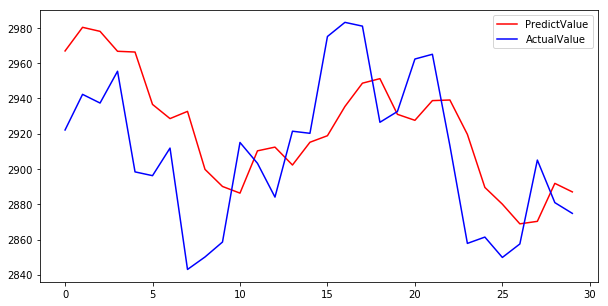

In [19]:
plt.figure(figsize=(10,5))
plt.subplot(1, 1, 1)
plt.plot(index_predict2, 'red', label='PredictValue')
plt.legend(loc='best')
plt.plot(np.array(index_real)[:,0], 'blue', label='ActualValue') 
plt.legend(loc='best')

In [21]:
df_GBR_SVR = ModelEvaluation(index_predict2, index_real, model_name = 'GBR_SVR_Model')
df_GBR_SVR

,ev,mae,mse,r2
GBR_SVR_Model,-0.272351,31.92954,1403.899401,-0.441158


# Conclusion

In [22]:
pd.concat([df_GBR, df_SVR, df_GBR_SVR], axis=0)

,ev,mae,mse,r2
GBR_Model,0.084507,30.393337,1426.833774,0.046767
SVR_Model,-0.246318,51.662584,4424.650770,-0.658574
GBR_SVR_Model,-0.272351,31.929540,1403.899401,-0.441158


* Unfortunately, it seems that none of the model has good prediction power, because the __ev__ and __r2__ are so small and even negative, 

  which indicate that stock prices cannot be predicted exactly! However, the "noisy"  data processing methods and time-series analysis model 
  
  as well as nonlinear machine learning regression model can serve as some useful tools to do further research in other fields.
  

* GBR prediction seems as the lag of previous stock prices, just predicting like a martingale.


* SVR performs badly in the begining of stock index prediction. As time goes by, it tends to predict the average(or expectation) price.


* The mix GBR/SVR model is just the simple mean of GBR and SVR. Its performance lies between GBR and SVR
